In [1]:
# Exchange Flow Layer Interface
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# Find the interface at zero velocity crossing point
def Layer_U(Qsg, hs):
    File = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '_rot/state_' + str(format(hs,'03d')) + '.nc')
    State = File.isel(X=range(120), Y=range(30,39), Xp1=range(121),T=range(275,337))
    
    #U0 = State.U.data.mean(axis=(0,2))
    #uzx = (U0[:,1:]+U0[:,:-1])/2 
    uzx = State.U.data.mean(axis=(0,2)) # Z, X
    X = uzx.shape[1]
    #itf = np.empty(X, dtype=int)
    #itf[[0,1]] = 0 # Remove data at fjord head
    itf = np.ma.masked_all(X, dtype=int)
    for i in range(2,X):
        l = np.where(uzx[:, i] < 0)[-1][0]
        itf[i] = l
    return itf

In [9]:
def transVol(Qsg, hs):
    #/Users/weiyangbao/Documents/Model_outputs/qf-only-hourly/state_
    File1 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '_rot/state_' + str(format(hs,'03d')) + '.nc')
    File2 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '_rot/grid_' + str(format(hs,'03d')) + '.nc')
    State = File1.isel(X=range(120), Y=range(30,39), Xp1=range(121),T=range(275,337))
    Grid = File2.isel(X=range(120), Xp1=range(121), Y=range(30,39))
    
    ut = State.U.data.mean(0)
    wt = State.W.data.mean(0)
    
    Area = np.empty([50, 9]) # Cross Y direction
    Area[:10, :] = 100
    Area[10:20, :] = 200
    Area[20:30, :] = 300
    Area[30:40, :] = 800
    Area[40:, :] = 1600


    HFacW = Grid.HFacW.data # vertical fraction of open cell at West face
    rA = Grid.rA.data # r face area at cell center
    itf = Layer_U(Qsg, hs)
    Vx1 = np.ma.masked_all(len(itf)) # Horizontal volume transport for the upper layer
    Vx2 = np.ma.masked_all(len(itf)) # Horizontal volume transport for the lower layer
    Vz = np.ma.masked_all(len(itf)-1) # Vertical volume transport through the interface
    for i in range(2,len(itf)):
        it = itf[i]
        #Vsm = ut[:,:,i] * HFacW[:,:,i] * Area
        #Vx1[i] = Vsm[Vsm>0].sum()
        #Vx2[i] = Vsm[Vsm<0].sum()
        Vx1[i] = np.sum(ut[:it,:,i] * HFacW[:it,:,i] * Area[:it,:])
        Vx2[i] = np.sum(ut[it:,:,i] * HFacW[it:,:,i] * Area[it:,:])
        #Vz[i] = np.sum(wt[it,:,i] * rA[:,i])
        
    return (Vx2)

In [10]:
Grid = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(700,'03d')) + '_rot/grid_' + str(format(12,'03d')) + '.nc')
grid = Grid.isel(X=range(120), Xp1=range(121), Y=range(30,39))
Xw = grid.Xp1.data
Xc = grid.X.data
#Xc[[48,71]], Xw[[48,72]] Slope range

In [11]:
Qsg = 700
hs = [9, 12, 15, 18]

ITF = np.ma.masked_all([len(hs), len(Xw)], dtype=int)
Q2 = np.ma.masked_all([len(hs), len(Xw)], dtype=int)
Q1 = np.ma.masked_all([len(hs), len(Xw)], dtype=int)
for i in range(len(hs)):
    ITF[i,:] = Layer_U(Qsg, hs[i])
    Q2[i,:] = transVol(Qsg, hs[i])
    
Q2

masked_array(
  data=[[--, --, -2234, -2821, -3022, -3129, -3215, -3298, -3378, -3445,
         -3491, -3519, -3535, -3544, -3552, -3560, -3568, -3576, -3582,
         -3590, -3597, -3601, -3602, -3600, -3597, -3594, -3593, -3594,
         -3598, -3604, -3610, -3616, -3623, -3626, -3627, -3627, -3630,
         -3636, -3647, -3664, -3689, -3719, -3756, -3799, -3847, -3899,
         -3954, -4013, -4076, -4142, -1292, -1269, -1245, -1261, -1283,
         -1330, -1355, -1387, -1415, -1441, -1465, -1482, -1492, -1495,
         -1498, -1498, -1498, -1496, -1494, -1491, -1489, -1487, -1485,
         -1485, -1486, -1487, -1491, -1495, -1500, -1506, -1513, -1519,
         -1527, -1534, -1543, -1551, -1560, -1569, -1578, -1588, -1598,
         -1608, -1618, -1629, -1639, -1649, -1659, -1669, -1676, -1685],
        [--, --, -2309, -2923, -3137, -3242, -3325, -3399, -3464, -3514,
         -3549, -3577, -3599, -3618, -3634, -3650, -3667, -3687, -3707,
         -3723, -3732, -3734, -3728, -3717, -37

In [ ]:
fig1, ax1 =plt.subplots(figsize=(16,8))

Xl, Xr = 40, 83
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'X (m)', size=20)
plt.ylabel(r'Z Index', size=20)
ax1.plot(Xw[Xl:Xr], ITF[0,Xl:Xr], '-', lw=2, label=r'9 m')
ax1.plot(Xw[Xl:Xr], ITF[1,Xl:Xr], '-', lw=2, label=r'12 m')
ax1.plot(Xw[Xl:Xr], ITF[2,Xl:Xr], '-', lw=2, label=r'15 m')
ax1.plot(Xw[Xl:Xr], ITF[3,Xl:Xr], '-', lw=2, label=r'18 m')
#ax1.axhline(y=ITF[0,48:73].mean(), color='k', linestyle='-')
ax1.axvline(x=Xw[75], color='k', linestyle='--')
ax1.axvline(x=Xw[62], color='k', linestyle='--')
ax1.legend(loc = 'best', fontsize=15)

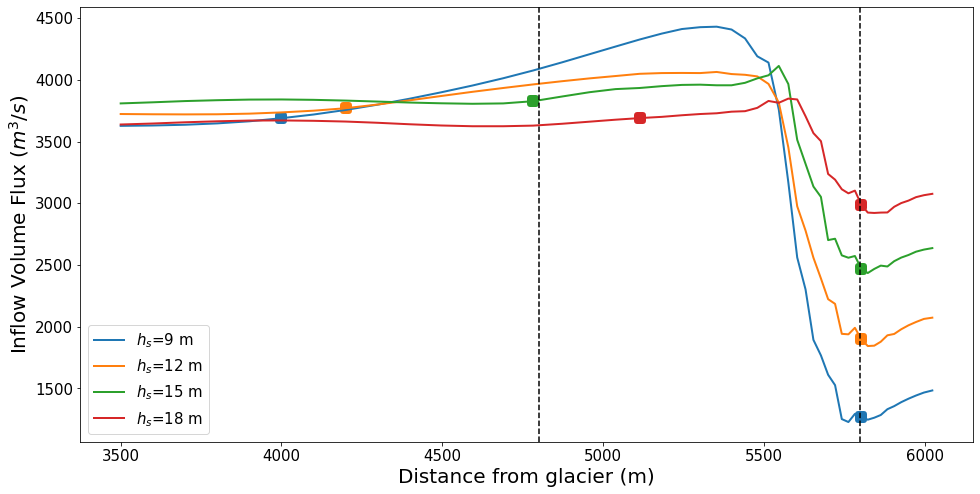

In [84]:
fig2, ax2 =plt.subplots(figsize=(16,8))

Xl, Xr = 35, 83
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'Distance from glacier (m)', size=20)
plt.ylabel(r'Inflow Volume Flux ($m^3/s$)', size=20)

ax2.plot(Xw[Xl:Xr], -Q2[0,Xl:Xr], '-', lw=2,label=r'$h_s$=9 m')
ax2.scatter(Xw[[40,72]], -Q2[0,[40,72]],marker='s',lw=6)

ax2.plot(Xw[Xl:Xr], -Q2[1,Xl:Xr], '-', lw=2, label=r'$h_s$=12 m')
ax2.scatter(Xw[[42,72]], -Q2[1,[42,72]],marker='s',lw=6)

ax2.plot(Xw[Xl:Xr], -Q2[2,Xl:Xr], '-', lw=2, label=r'$h_s$=15 m')
ax2.scatter(Xw[[48,72]], -Q2[2,[48,72]],marker='s',lw=6)

ax2.plot(Xw[Xl:Xr], -Q2[3,Xl:Xr], '-', lw=2, label=r'$h_s$=18 m')
ax2.scatter(Xw[[52,72]], -Q2[3,[52,72]],marker='s',lw=6)
#ax2.axhline(y=0, color='k', linestyle='-')
ax2.axvline(x=4800, color='k', linestyle='--')
ax2.axvline(x=5800, color='k', linestyle='--')
ax2.legend(loc = 'best', fontsize=15)

In [85]:
fig_path = "/Users/weiyangbao/Documents/Results_Figs/Parameter/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
fig2.savefig(fig_path + '/EntrainmentRange.png', dpi=200, bbox_inches='tight')